<h1>TrDCN</h1>
<h2>-Transformer with Dynamic Counting Network</h2>

模型架构：

原始图像 / 掩码 ——> 编码器(ViT) ——> 图像 / 掩码特征

图像特征 + 掩码特征 ——> 基于动态卷积的符号计数网络(MSCM) ——> 计数向量

图像特征 + 掩码特征 + 计数向量 ——> 解码器(Transformer Decoder) ——> 生成文本序列

<h2>第一部分：数据集加载和预处理</h2>
数据集下载链接: 

https://ai.100tal.com/dataset

从文件路径 data_dir 读取后，进行预处理操作：

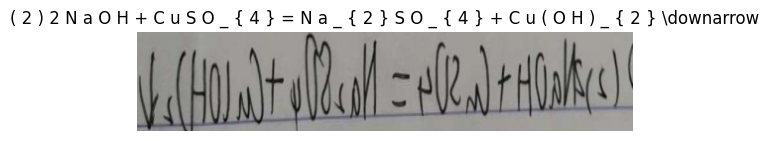

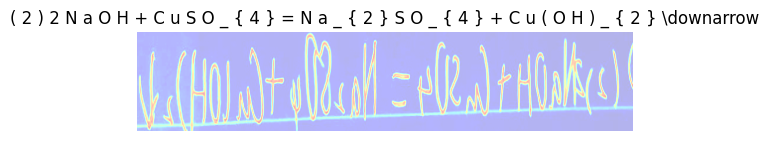

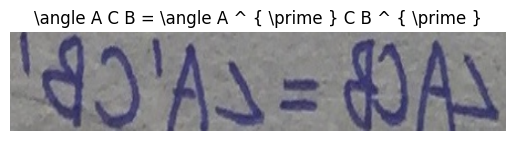

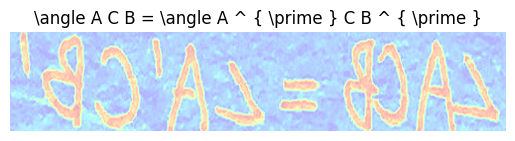

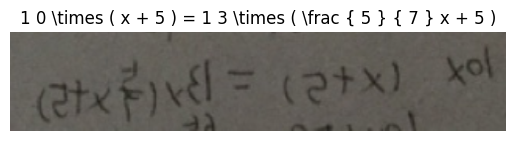

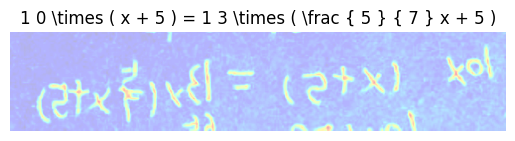

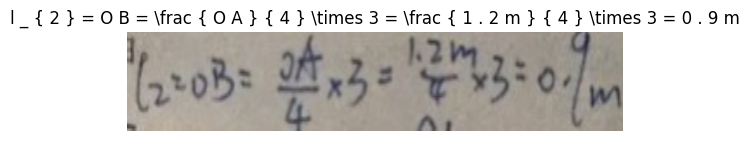

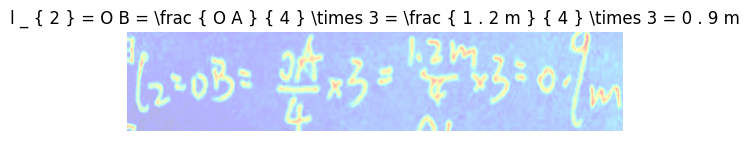

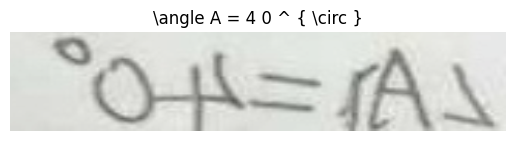

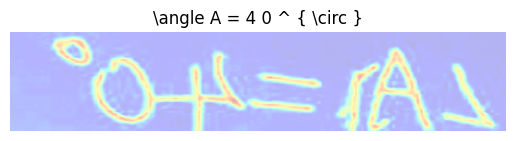

In [ ]:
from LoadingData import Loading_HME100K, Preprocess_Data
from UtilityFunctions import Visualize_ProcessedSample
data_dir = ...
data = Loading_HME100K(data_root=data_dir)
data = Preprocess_Data(data=data)

for i in range(5):
    Visualize_ProcessedSample(data, i)

可根据设备的具体情况，在定义超参数的 **Hyperparameters.py** 中修改读取的样本数量和批量大小

In [1]:
from LoadingData import Loading_HME100K_Dataset
data_dir = "D:\\HME100K"

vocab, train_dataloader = Loading_HME100K_Dataset(data_root=data_dir, mode='train')
batch = next(iter(train_dataloader))
images, masks, labels, lengths = batch

print("Training Data:")
print(f"Images shape:     {images.shape}")       # torch.Size([B, 3, 100, 500])
print(f"Masks shape:      {masks.shape}")        # torch.Size([B, 1, 100, 500])
print(f"Token IDs shape:  {labels.shape}")       # torch.Size([B, 150])
print(f"Lengths:          {lengths.shape}\n")    # torch.Size([B])

_, test_dataloader = Loading_HME100K_Dataset(data_root=data_dir, mode='test')
batch = next(iter(test_dataloader))
images, masks, text = batch
print("Testing Data:")
print(f"Images shape:     {images.shape}")
print(f"Masks shape:      {masks.shape}") 
for i in range(10):
    print(text[i])

Training Data:
Images shape:     torch.Size([64, 3, 100, 500])
Masks shape:      torch.Size([64, 1, 100, 500])
Token IDs shape:  torch.Size([64, 150])
Lengths:          torch.Size([64])

Testing Data:
Images shape:     torch.Size([64, 3, 100, 500])
Masks shape:      torch.Size([64, 1, 100, 500])
\frac { 5 } { 1 4 } = \frac { 1 } { x }
- 2 x ^ { 4 } - x ^ { 2 } + 5 = ( - x ^ { 2 } + 1 ) ( x + a ) + b = x ^ { 2 } + a x + 3 x - 3 a - b
S _ { \Delta D B F } = \frac { 3 } { 8 } S _ { \Delta A B C } = \frac { 3 } { 8 } \times \frac { 1 5 } { 2 } = \frac { 4 5 } { 1 6 }
: x _ { 1 } = - \frac { 3 } { 5 }
7 5 \div ( 7 5 + 2 5 ) = 7 5 \div 1 0 0 = 7 5 \%
y = 3 . y = - 1
x _ { 1 } = - 6 x _ { 2 } = 4
2 3 . 5 + \frac { 1 } { 2 } x = 1 3 + x
\frac { 9 } { 1 0 } \div \frac { 3 } { 5 } = \frac { ( 9 ) } { ( 1 0 ) } \textcircled { \times } \frac { ( 5 ) } { ( 3 ) } = ( \frac { 2 } { 3 } )
= \frac { ( 7 + 1 8 ) + ( 9 - 1 4 ) i } { 5 } = \frac { 2 5 - 5 i } { 5 } = 5 - i


<h2>第二部分：模块使用</h2>

<h3>1、编码器(ViT, Vision Transformer)</h3>

前向传播输入：**原始图像[B, 3, 100, 500]** 或 **原始掩码[B, 1, 100, 500]**

统一输出大小：**[B, 128, 2, 10]**

In [7]:
from Encoder import ViT
import torch

encoder = ViT()
nums = 0
for name, param in encoder.named_parameters():
    nums += param.numel()

print(nums / (1000 ** 2), 'M')

image = torch.ones((1, 3, 100, 500))
output = encoder(image)
print(output.shape)

mask = torch.ones((1, 1, 100, 500))
output = encoder(mask)
print(output.shape)


2.469888 M
torch.Size([1, 128, 2, 10])
torch.Size([1, 128, 2, 10])


<h3>2、基于动态卷积的符号计数网络(Multi-Scale Counting Module, MSCM)</h3>

输入：**图像特征[B, 128, 2, 10]** 和 **掩码特征[B, 128, 2, 10]**

输出：**符号计数向量[B, len(Vocab)]** 和 **密度图[B, len(Vocab), 2, 10]**

In [9]:
from DynamicCounting import CountingDecoder
import torch

mscm = CountingDecoder(in_channels=128, out_channels=130, kernel_list=[3, 5])
nums = 0
for name, param in mscm.named_parameters():
    nums += param.numel()

print(nums / (1000 ** 2), 'M')

input = torch.ones((1, 128, 2, 10))
mask = torch.randn((1, 128, 2, 10))
count_vector, density_map = mscm(input, mask)
print(count_vector.shape)
print(density_map.shape)

9.013413 M
torch.Size([1, 130])
torch.Size([1, 130, 2, 10])


<h3>3、解码器(Transformer Decoder)</h3>

输入：**图像特征[B, 128, 2, 10]** 、 **掩码特征[B, 128, 2, 10]** 、**标签[B, Num_steps]** 、**标签长度[B]** 、 **计数向量[B, len(vocab)]**  

输出：**预测概率[B, Num_steps, len(Vocab)]** 和 **注意力权重None(可根据实际情况修改代码以输出)**

In [6]:
from Decoder import TransformerDecoder
import torch

decoder = TransformerDecoder(vocab)
nums = 0
for name, param in decoder.named_parameters():
    nums += param.numel()

print(nums / (1000 ** 2), 'M')


cnn_features = torch.ones(32, 128, 10, 10)     # [B, C, H, W]
mask_features  = torch.randn(32, 128, 10, 10)  # [B, C, H, W]
labels = torch.randint(0, 112, (32, 20))       # [B, Num_steps]
seq_lens = torch.randint(10, 20, (32,))        # [B]
counting_preds = torch.randn(32, len(vocab))   # [B, len(vocab)]

word_probs, _ = decoder(cnn_features, mask_features, labels, counting_preds, seq_lens)
print(word_probs.shape)
print(word_probs[:3, :5, :5])

1.131539 M
torch.Size([32, 20, 147])
tensor([[[ 8.3763e-03, -5.1268e-01,  5.1925e-04,  4.3019e-01,  3.2801e-01],
         [ 5.1079e-02, -3.8983e-01, -1.8373e-01, -9.3220e-02,  9.2768e-01],
         [ 3.6778e-01, -5.0227e-01,  2.2031e-01,  1.2076e-01,  1.0208e+00],
         [ 3.8590e-01, -6.3244e-01,  3.9529e-01,  3.0509e-02,  5.4165e-02],
         [-4.4133e-01, -3.8625e-01,  4.3699e-01,  9.4404e-01,  2.4522e-01]],

        [[ 1.3049e-01, -6.6516e-01, -1.5879e-01,  2.0011e-01, -9.5046e-03],
         [-1.3248e-02, -3.8604e-01, -3.6463e-01,  8.0482e-01,  6.8409e-01],
         [ 4.5474e-01, -4.0915e-01, -9.4191e-01, -2.8040e-01,  2.6053e-01],
         [-5.4989e-01,  1.1481e-01, -5.4911e-01,  8.5682e-01,  3.9775e-01],
         [ 2.5481e-01, -5.1084e-01, -7.9531e-01,  3.7707e-01,  1.2386e-01]],

        [[ 1.1465e+00, -1.0296e+00, -4.1690e-01, -1.8240e-01,  6.2086e-01],
         [ 6.4910e-01, -1.2920e+00, -5.5960e-01,  4.1391e-02,  1.2340e+00],
         [ 9.2439e-01, -6.5935e-01, -3.9943e-01

<h2>第三部分：模型训练和预测</h2>

定义模型：

In [3]:
from EntireModel import TrDCN
model = TrDCN(vocab)

Encoder params: 2.469888 M
Counting params: 9.022117 M
Decoder params: 1.131539 M
Total params: 12.623544 M


调用训练函数：

由于本机计算资源不足，所以训练周期和训练样本调为较小值

虽然看起来训练效果不错，损失收敛了，但是预测能力可能不佳……

epoch 1, batch 1, loss: 7.770201683044434
epoch 1, batch 2, loss: 7.517855644226074
epoch 1, batch 3, loss: 7.153595924377441
epoch 1, batch 4, loss: 6.525247573852539
epoch 1, batch 5, loss: 6.206044673919678
epoch 1, batch 6, loss: 6.037103652954102
epoch 1, batch 7, loss: 6.061975479125977
epoch 1, batch 8, loss: 5.708975315093994
epoch 1, batch 9, loss: 5.638342380523682
epoch 1, batch 10, loss: 5.534299850463867
epoch 1, batch 11, loss: 5.73754358291626
epoch 1, batch 12, loss: 5.397274017333984
epoch 1, batch 13, loss: 5.187524318695068
epoch 1, batch 14, loss: 5.202476501464844
epoch 1, batch 15, loss: 5.22095251083374
epoch 1, batch 16, loss: 4.969466209411621
epoch 2, batch 1, loss: 4.970411777496338
epoch 2, batch 2, loss: 4.844757080078125
epoch 2, batch 3, loss: 4.839383602142334
epoch 2, batch 4, loss: 4.777252197265625
epoch 2, batch 5, loss: 4.801568031311035
epoch 2, batch 6, loss: 4.623414516448975
epoch 2, batch 7, loss: 4.559104919433594
epoch 2, batch 8, loss: 4.472

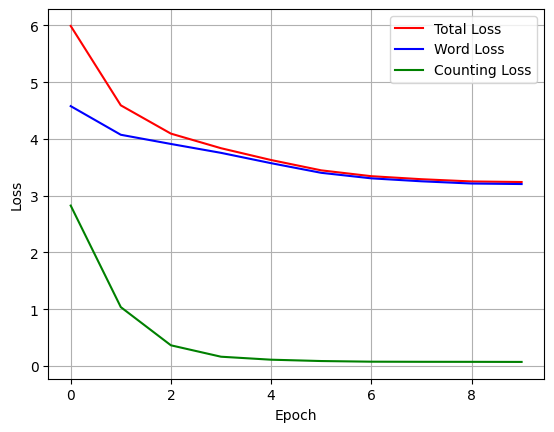

Training finished!


In [5]:
from Training import Trainer
trainer = Trainer(model=model, dataloader=train_dataloader)
trainer.train()

模型预测：

可视化预测函数 Visualize_Prediction 调用了模型中定义的预测函数 predict

由于训练有限，同时模型架构可能需优化改进，模型预测能力不足，会生成重复的、无意义的词元 T^T

但是我认为这个模型架构设计还是很有意义的，因为这是我设计的第一个模型，同时也是第一个代码量过千的 python 项目

<span style="color:yellow">
P.S. 由于预测函数 predict 在处理批量时需考虑样本是否被处理完成，而生成的序列是不定长的，所以经常会报一些处理样本数量未对齐的错误……

时间问题，我就不再花时间修改重构了，所以还希望可以看到这个项目的各位能修改优化我的代码，让这个模型可以更好的训练和预测！不胜感激！

Pred: z z z z z z z z z z z z z z z z z z z Y z z z z z z z z z z z z z z z z z z z z z z z z z Y z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z Y z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z


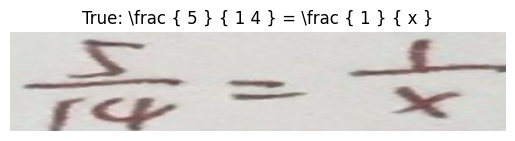

Pred: z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z


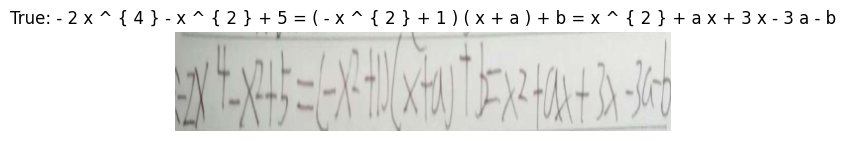

Pred: z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z


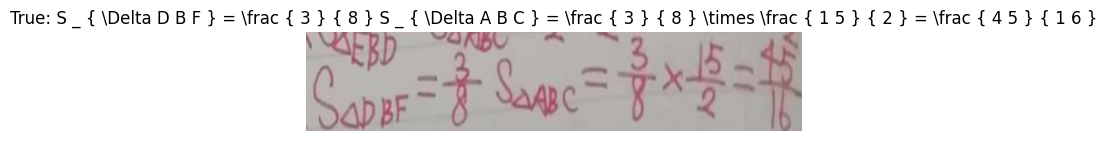

Pred: Y z z z z z z z z z z z z z z z z z z Y Y z Y z z Y Y z z z z Y z z z z z z z Y Y z z z z z Y z z Y z Y z z z Y Y Y Y Y z z z z z z z z z z z z z z z z z z z Y z z z z z z z z z z z z z z z z z z z Y Y z Y z z z z z z z z Y z z z z z z Y z Y Y Y z z z z z z z z z z z z z z z z z z z z z z z z z z z


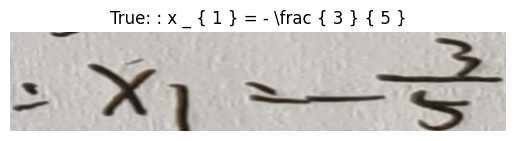

Pred: z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z z


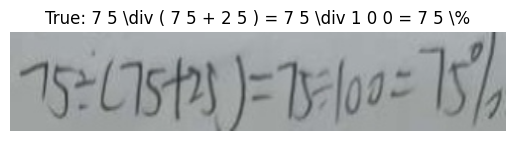

In [4]:
from UtilityFunctions import Visualize_Prediction
Visualize_Prediction(model=model, dataloader=test_dataloader)